In [ ]:
!pip install split-folders

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(tf.__version__)

2.6.2


In [ ]:
data_dir = '../input/braintumor/Datasets(2)/Training'
batch_size=16
image_size=224

In [ ]:
splitfolders.ratio(data_dir, output='datsets', ratio=(0.8, 0.1003, 0.0997))

Copying files: 1019 files [00:02, 343.87 files/s]


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/working/datsets/train/',
  label_mode ='int',
  image_size=(image_size, image_size),
  shuffle = True,
  seed=123,
  batch_size=16
)

Found 815 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/working/datsets/val/',
  label_mode ='int',
  image_size=(image_size, image_size),
  shuffle = False,
  batch_size=16
)

Found 102 files belonging to 2 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/working/datsets/test/',
  label_mode ='int',
  image_size=(image_size, image_size),
  shuffle = False,
  batch_size=16
)

Found 102 files belonging to 2 classes.


In [ ]:
class_names = test_ds.class_names
print(class_names)

['no_tumor', 'tumor']


In [ ]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier

In [ ]:
normalization_layer1 = tf.keras.layers.Rescaling(1./255)
normalization_layer2 = tf.keras.layers.Normalization(mean=[0.5, 0.5, 0.5], 
                      variance=[np.square(0.5), 
                                np.square(0.5), 
                                np.square(0.5)])

2022-04-03 19:07:31.520158: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


-0.9867 0.9931


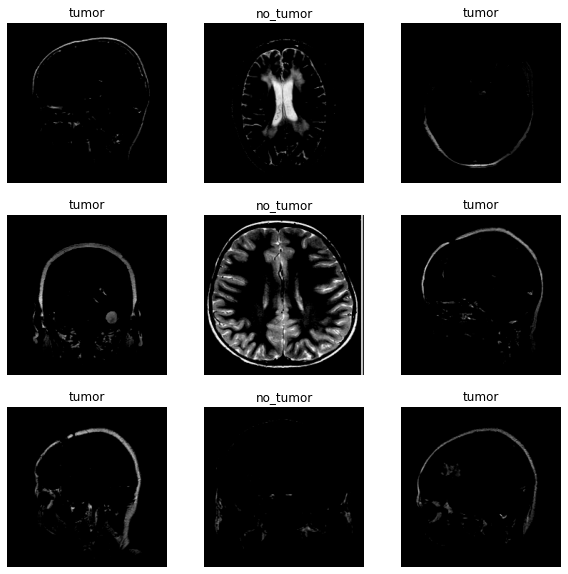

In [ ]:
train_ds_normalized = train_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(train_ds_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in train_ds_normalized:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

-0.9867 0.9931


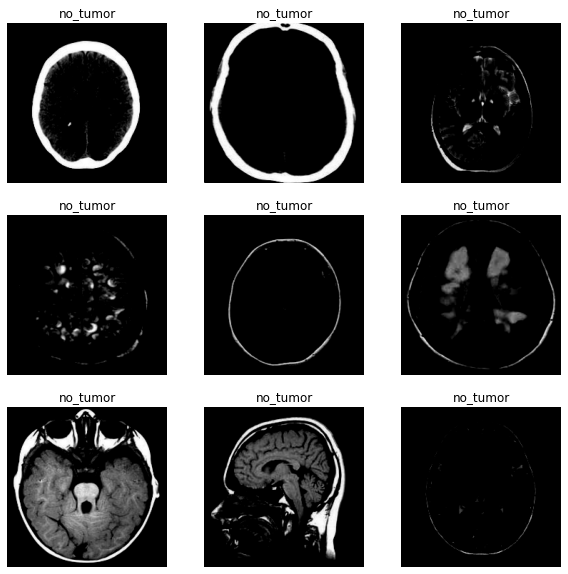

In [ ]:
val_ds_normalized = val_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(val_ds_normalized))

print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in val_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

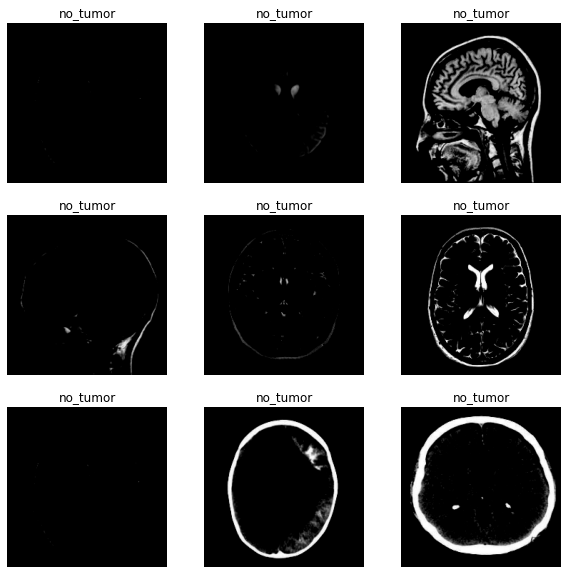

In [ ]:
test_ds_normalized = test_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(test_ds_normalized))
plt.figure(figsize=(10, 10))
for images, labels in test_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
y_test = [label for images, labels in test_ds_normalized for label in labels.numpy()]

In [ ]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Tensorflow and Keras')
   
    y_prediction = np.argmax(y_pred,axis=1)
    report = classification_report(y_test, y_prediction, target_names=class_names)
    print(f'{report}')

    fig, ax = plt.subplots(figsize=(7,7)) 
    ax.set_title(f'Confusion Matrix {model} Tensorflow and Keras')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)

In [ ]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                  "id": 1,
                  "variables":['accuracy', 'val_accuracy'],
                  "labels":['Training Accuracy', 'Validation Accuracy'],
                  "legend":'lower right',
                  "title":f'Accuracy Tensorflow and Keras - {model}',
                  "ylabel":'Accuracy'
              },{ 
                  "id": 2,
                  "variables":['loss', 'val_loss'],
                  "labels":['Training Loss', 'Validation Loss'],
                  "legend":'upper right',
                  "title":f'Loss Tensorflow and Keras - {model}',
                  "ylabel":'Loss'
              }]
    epochs_range = range(25)
    for tab in tab_plot: 
          plt.subplot(1, 2, tab['id'])
          plt.plot(epochs_range, history.history[tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
          plt.plot(epochs_range, history.history[tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
          plt.legend(loc=tab['legend'])
          plt.title(tab['title'])
          plt.xlabel('Epochs')
          plt.ylabel(tab['ylabel'])
    plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2 
mobilenet =  MobileNetV2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3),alpha=1)

In [ ]:
model = mobilenet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(2,activation='softmax')(model)
model = tf.keras.models.Model(inputs=mobilenet.input, outputs = model)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train Mobilenetv2 Tensorflow and Keras')
history_mobilenet_v2 = model.fit(train_ds_normalized,  validation_data=(val_ds_normalized), epochs=25)

Train Mobilenetv2 Tensorflow and Keras
Epoch 1/25
51/51 [==============================] - 38s 115ms/step - loss: 0.4050 - accuracy: 0.8577 - val_loss: 2.9375 - val_accuracy: 0.7255
Epoch 2/25
51/51 [==============================] - 5s 100ms/step - loss: 0.1852 - accuracy: 0.9288 - val_loss: 0.4710 - val_accuracy: 0.9020
Epoch 3/25
51/51 [==============================] - 5s 103ms/step - loss: 0.0632 - accuracy: 0.9730 - val_loss: 0.4015 - val_accuracy: 0.9608
Epoch 4/25
51/51 [==============================] - 5s 103ms/step - loss: 0.0787 - accuracy: 0.9755 - val_loss: 3.1468 - val_accuracy: 0.7255
Epoch 5/25
51/51 [==============================] - 5s 97ms/step - loss: 0.1029 - accuracy: 0.9620 - val_loss: 0.6488 - val_accuracy: 0.8725
Epoch 6/25
51/51 [==============================] - 5s 99ms/step - loss: 0.0330 - accuracy: 0.9877 - val_loss: 2.2392 - val_accuracy: 0.8529
Epoch 7/25
51/51 [==============================] - 6s 101ms/step - loss: 0.0790 - accuracy: 0.9669 - val_loss

Test Mobilenetv2 Tensorflow and Keras
              precision    recall  f1-score   support

    no_tumor       1.00      0.78      0.88        50
       tumor       0.83      1.00      0.90        52

    accuracy                           0.89       102
   macro avg       0.91      0.89      0.89       102
weighted avg       0.91      0.89      0.89       102



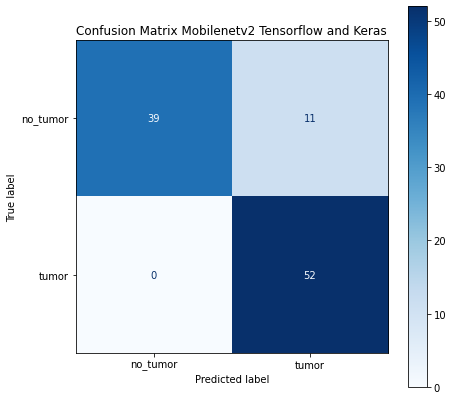

In [ ]:
y_pred_mobilenet_v2 = model.predict(test_ds_normalized)
display_report_and_matrix(y_pred_mobilenet_v2, 'Mobilenetv2')

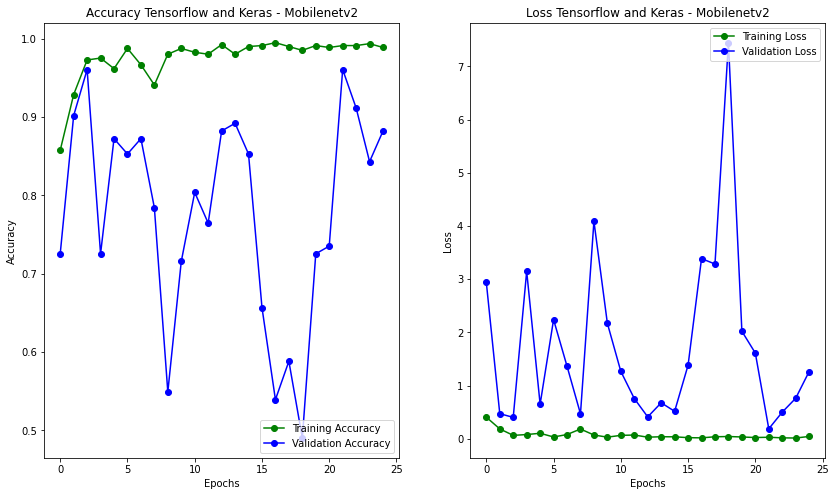

In [ ]:
display_plot(history_mobilenet_v2, 'Mobilenetv2')

In [ ]:
from tensorflow.keras.applications import DenseNet121
dense =  DenseNet121(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model_densenet = dense.output
model_densenet = tf.keras.layers.GlobalAveragePooling2D()(model_densenet)
model_densenet = tf.keras.layers.Dense(2,activation='softmax')(model_densenet)
model_densenet = tf.keras.models.Model(inputs=dense.input, outputs = model_densenet)

In [ ]:
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train DenseNet121 Tensorflow and Keras')
history_densenet = model_densenet.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=25)

Train DenseNet121 Tensorflow and Keras
Epoch 1/25
51/51 [==============================] - 19s 175ms/step - loss: 0.4445 - accuracy: 0.8601 - val_loss: 25.7746 - val_accuracy: 0.5098
Epoch 2/25
51/51 [==============================] - 7s 137ms/step - loss: 0.2495 - accuracy: 0.9104 - val_loss: 1.8576 - val_accuracy: 0.7745
Epoch 3/25
51/51 [==============================] - 7s 139ms/step - loss: 0.1795 - accuracy: 0.9325 - val_loss: 0.5304 - val_accuracy: 0.8824
Epoch 4/25
51/51 [==============================] - 7s 133ms/step - loss: 0.1324 - accuracy: 0.9571 - val_loss: 4.5893 - val_accuracy: 0.5980
Epoch 5/25
51/51 [==============================] - 7s 141ms/step - loss: 0.1404 - accuracy: 0.9497 - val_loss: 0.4640 - val_accuracy: 0.8824
Epoch 6/25
51/51 [==============================] - 7s 138ms/step - loss: 0.0995 - accuracy: 0.9669 - val_loss: 2.5063 - val_accuracy: 0.5980
Epoch 7/25
51/51 [==============================] - 7s 131ms/step - loss: 0.0845 - accuracy: 0.9644 - val_l

Test DenseNet121 Tensorflow and Keras
              precision    recall  f1-score   support

    no_tumor       0.81      0.88      0.85        50
       tumor       0.88      0.81      0.84        52

    accuracy                           0.84       102
   macro avg       0.84      0.84      0.84       102
weighted avg       0.85      0.84      0.84       102



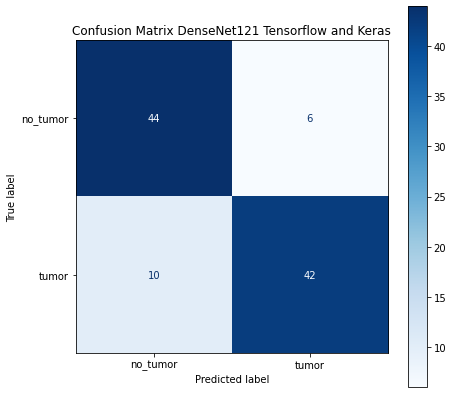

In [ ]:
y_pred_densenet = model_densenet.predict(test_ds_normalized)
display_report_and_matrix(y_pred_densenet, 'DenseNet121')

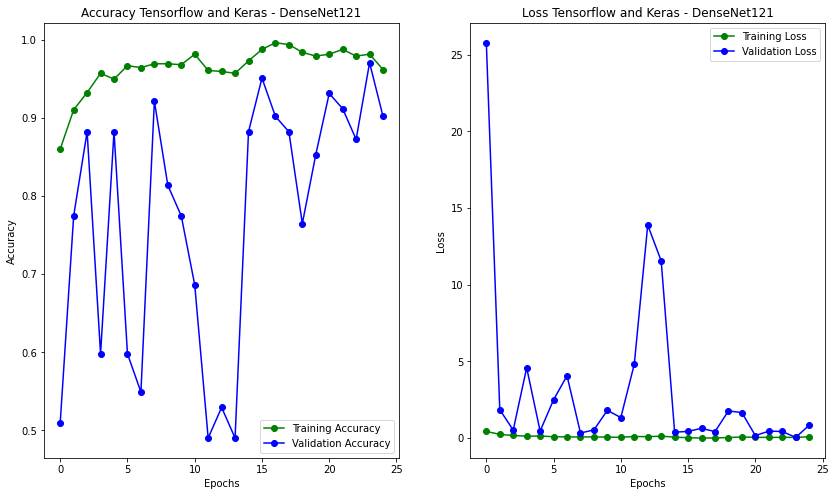

In [ ]:
display_plot(history_densenet, 'DenseNet121')

In [ ]:
from tensorflow.keras.applications import ResNet50 
resnet =  ResNet50(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.applications import ResNet50 
resnet =  ResNet50(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model_resnet50 = resnet.output
model_resnet50 = tf.keras.layers.GlobalAveragePooling2D()(model_resnet50)

model_resnet50 = tf.keras.layers.Dense(2,activation='softmax')(model_resnet50)
model_resnet50 = tf.keras.models.Model(inputs=resnet.input, outputs = model_resnet50)

In [ ]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train Resnet50 Tensorflow and Keras')
history_resnet50 = model_resnet50.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=25)

Train Resnet50 Tensorflow and Keras
Epoch 1/25
51/51 [==============================] - 12s 145ms/step - loss: 0.7720 - accuracy: 0.7902 - val_loss: 821.0109 - val_accuracy: 0.4902
Epoch 2/25
51/51 [==============================] - 6s 112ms/step - loss: 0.4006 - accuracy: 0.8613 - val_loss: 781.0601 - val_accuracy: 0.4902
Epoch 3/25
51/51 [==============================] - 6s 119ms/step - loss: 0.2954 - accuracy: 0.8957 - val_loss: 0.6951 - val_accuracy: 0.4902
Epoch 4/25
51/51 [==============================] - 6s 119ms/step - loss: 0.2764 - accuracy: 0.8982 - val_loss: 7.2037 - val_accuracy: 0.5098
Epoch 5/25
51/51 [==============================] - 6s 118ms/step - loss: 0.2085 - accuracy: 0.9202 - val_loss: 0.7145 - val_accuracy: 0.5098
Epoch 6/25
51/51 [==============================] - 6s 111ms/step - loss: 0.1272 - accuracy: 0.9534 - val_loss: 1.0734 - val_accuracy: 0.5098
Epoch 7/25
51/51 [==============================] - 6s 114ms/step - loss: 0.1223 - accuracy: 0.9521 - val_l

Test ResNet50 Tensorflow and Keras
              precision    recall  f1-score   support

    no_tumor       0.81      0.94      0.87        50
       tumor       0.93      0.79      0.85        52

    accuracy                           0.86       102
   macro avg       0.87      0.86      0.86       102
weighted avg       0.87      0.86      0.86       102



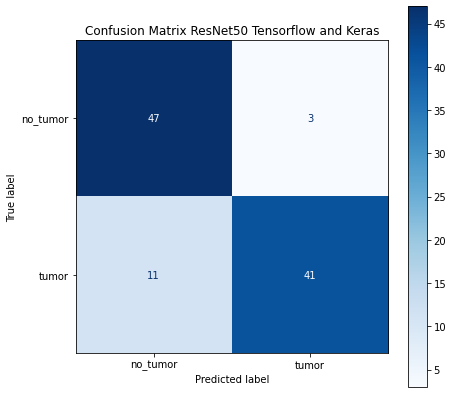

In [ ]:
y_pred_resnet50 = model_resnet50.predict(test_ds_normalized)
display_report_and_matrix(y_pred_resnet50, 'ResNet50')

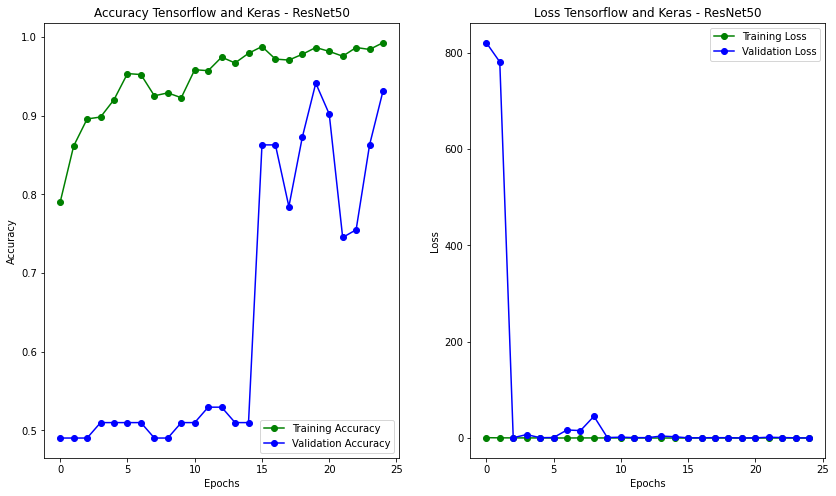

In [ ]:
display_plot(history_resnet50, 'ResNet50')